1: Import the dataset and libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Brain_MRI

/content/drive/My Drive/Colab Notebooks/Brain_MRI


In [ ]:
#Storing the data in a pandas dataframe
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
#Checking if we have a balanced dataset
num_tumours = (brain_df['mask'] == 0).sum()
num_healthy = (brain_df['mask'] != 0).sum()
print("Tumours: %d" % num_tumours)
print("Healthy: %d" % num_healthy)

Tumours: 2556
Healthy: 1373


In [ ]:
#Plotting this information on a barchart using plotly

import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(255, 0, 0)', marker_line_color = 'rgb(255, 0, 0)', marker_line_width = 3, opacity = 0.7)

fig.show()

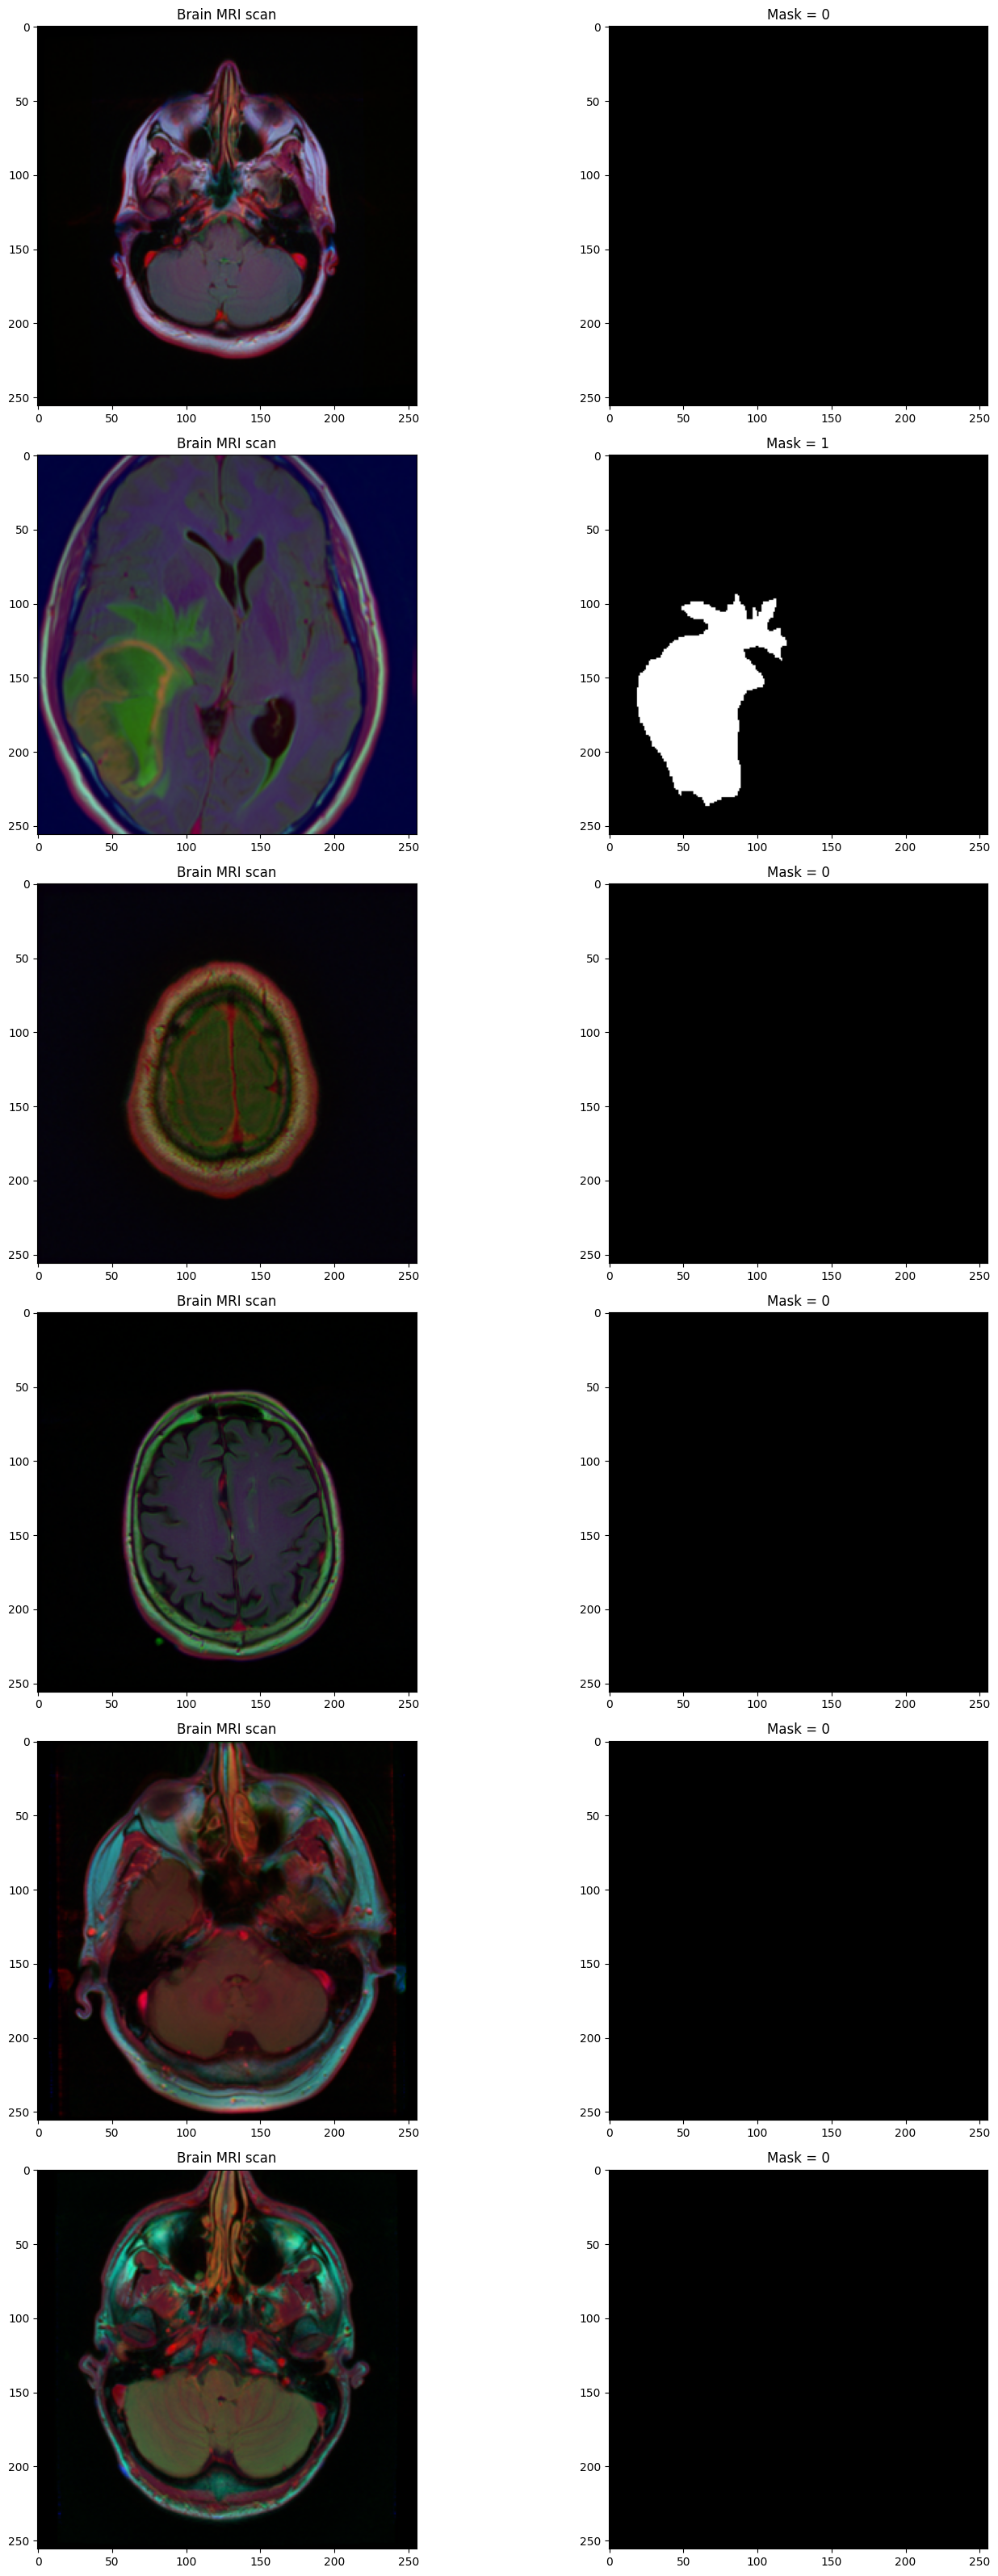

In [ ]:
#Visualise some images
import random
fig, axes = plt.subplots(6, 2, figsize = (16, 32))

count = 0
for i in range(6):
  k = random.randint(0, len(brain_df))
  axes[count][0].title.set_text("Brain MRI scan")
  axes[count][0].imshow(cv2.imread(brain_df['image_path'][k]))
  axes[count][1].title.set_text("Mask = " + str(brain_df['mask'][k]))
  axes[count][1].imshow(cv2.imread(brain_df['mask_path'][k]))
  count += 1

fig.tight_layout()

In [ ]:
#Plot 12 MRI scans from only sick patients showing the mask and the scan superimposed on each other

brain_df_sick = brain_df.loc[brain_df['mask'] == 1]
brain_df_sick = brain_df_sick.reset_index()
brain_df_sick

,index,patient_id,image_path,mask_path,mask
0,445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
1,507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
2,551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
3,555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
4,617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1
...,...,...,...,...,...
1368,3785,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,1
1369,3795,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,1
1370,3797,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,1
1371,3806,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,1


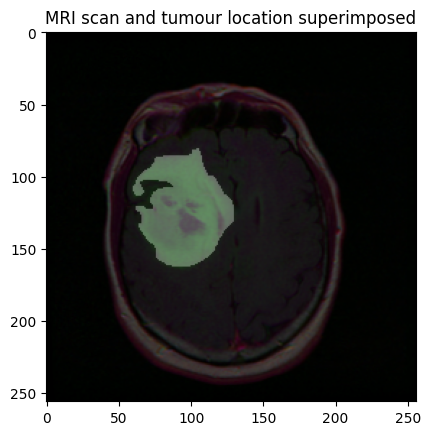

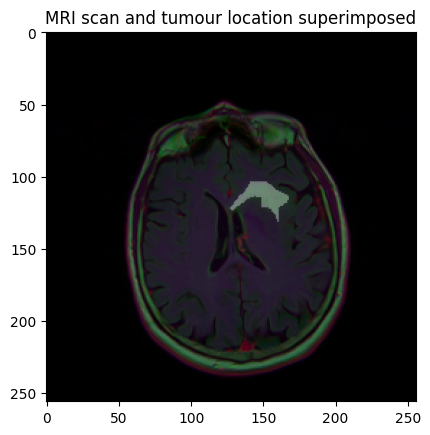

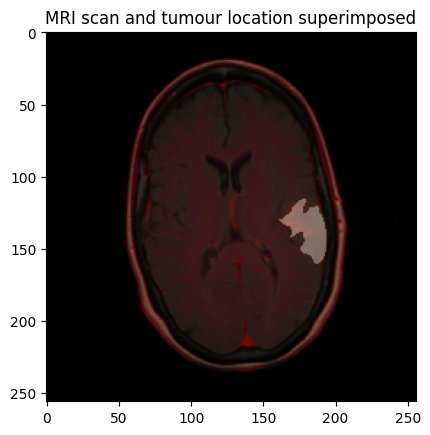

In [ ]:
import random

count = 0
for i in range(3):
  plt.figure()
  k = random.randint(0, len(brain_df_sick))
  plt.title("MRI scan and tumour location superimposed")
  plt.imshow(cv2.imread(brain_df_sick.image_path[k]))
  plt.imshow(cv2.imread(brain_df_sick.mask_path[k]), alpha = 0.3, cmap = 'jet')
  count += 1
fig.tight_layout()

Train the model to classify tumours and do segmentation on the tumours

In [ ]:
brain_df_train = brain_df.drop(columns = ["patient_id"])
brain_df_train.shape

(3929, 3)

In [ ]:
from sklearn.model_selection import train_test_split

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
train, test = train_test_split(brain_df_train, test_size = 0.15)
train.head(10)

,image_path,mask_path,mask
2238,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_21...,TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_21...,0
3345,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_37...,TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_37...,0
2608,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_25...,TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_25...,1
2385,TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_22...,TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_22...,1
3306,TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_36...,TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_36...,1
3722,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_52...,TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_52...,1
3396,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_39...,TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_39...,1
1800,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17...,TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17...,0
761,TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_7.tif,TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_7_...,0
1353,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13...,TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_13...,0


In [ ]:
!pip install Keras-Preprocessing

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1.0/255.0, validation_split = 0.15)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256,256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = './',
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256)
)

/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 2837 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 589 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
#Grab the pre-trained ResNet50 model online

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [ ]:
#Freeze all weights in ResNet50

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
#Adding the dense neural network at the end of the CNN

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name = "flatten")(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
#Compiling the model using Adam (SGD)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
#Adding checkpoint and earlystopping

earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
checkpointer = ModelCheckpoint(filepath = 'classifier-resnet-weights.hdf5', verbose = 1, save_best_only = True)

In [ ]:
#Running the model

history = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, epochs = 10, validation_data = valid_generator, validation_steps = valid_generator.n // 16, callbacks = [checkpointer, earlyStopping])

Epoch 1/10
177/177 [==============================] - ETA: 0s - loss: 0.7059 - accuracy: 0.7358
Epoch 1: val_loss improved from inf to 1.59674, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 712s 4s/step - loss: 0.7059 - accuracy: 0.7358 - val_loss: 1.5967 - val_accuracy: 0.6673
Epoch 2/10
177/177 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8401
Epoch 2: val_loss improved from 1.59674 to 1.11024, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 43s 243ms/step - loss: 0.3831 - accuracy: 0.8401 - val_loss: 1.1102 - val_accuracy: 0.6694
Epoch 3/10
177/177 [==============================] - ETA: 0s - loss: 0.3341 - accuracy: 0.8660
Epoch 3: val_loss improved from 1.11024 to 0.73995, saving model to classifier-resnet-weights.hdf5
177/177 [==============================] - 46s 260ms/step - loss: 0.3341 - accuracy: 0.8660 - val_loss: 0.7400 - val_accuracy: 0.6694
Epoch 4/10
177/177 

In [ ]:
#Saving the model to a .json file for future use
import json
model_json = model.to_json()

with open("classifier-resnet-model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
#Importing our saved weights and model
with open("classifier-resnet-model.json", "r") as json_file:
  json_savedModel = json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights("classifier-resnet-weights.hdf5")
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
#Applying the model to our test data

model_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose = 1)

36/36 [==============================] - 281s 8s/step


In [ ]:
predict = []

for i in range(len(model_predict)):
  predict.append(str(np.argmax(model_predict[i, :])))

predict = np.asarray(predict)

In [ ]:
original = np.asarray(test['mask'][:len(predict)])

In [ ]:
original.shape

(576,)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.9357638888888888

<Axes: >

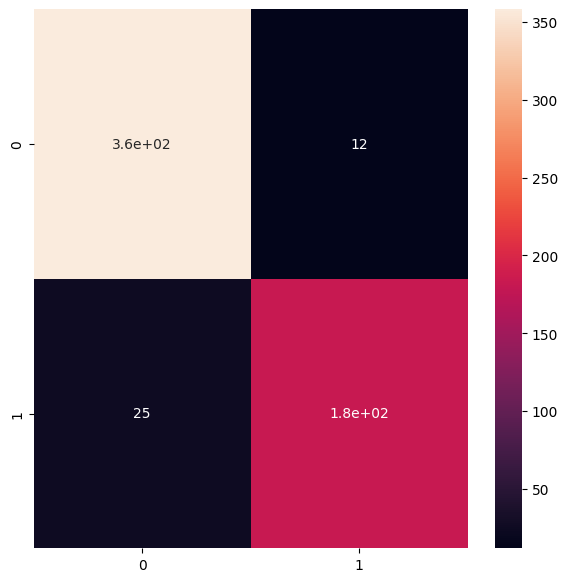

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True)

In [ ]:
#Find model accuracy

from sklearn.metrics import classification_report
report = classification_report(original, predict, labels = [0, 1])
print(report)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       370
           1       0.94      0.88      0.91       206

   micro avg       0.94      0.94      0.94       576
   macro avg       0.94      0.92      0.93       576
weighted avg       0.94      0.94      0.94       576



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


# Training an image segmentation model on the train data

In [ ]:
#Get only the cancerous brain scans
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.head()

,patient_id,image_path,mask_path,mask
445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1


In [ ]:
#Split into training, validation, testing data
X_train, X_val = train_test_split(brain_df_mask, test_size = 0.15)
X_test, X_val = train_test_split(X_val, test_size = 0.5)

In [ ]:
#Creating separate lists for the inputs (image path) and outputs (mask path)

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask = list(X_val.mask_path)

In [ ]:
from utilities import DataGenerator

#Produce image generators for training and validation sets

training_generator = DataGenerator(train_ids, train_mask)
val_generator = DataGenerator(val_ids, val_mask)

In [ ]:
#Res-block code to use in ResUNet

def resblock(X, f):

  #Input copy to pass through short path
  X_copy = X

  #Main path
  X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer = 'he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_normal')(X)
  X = BatchNormalization()(X)

  #Short path
  X_copy = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer = 'he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

  #Add the two paths together and activate
  X = Add()([X, X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
#Upsample block which takes in the passed in data from the encoding arm and concatenates in with current image data

def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])
  return merge

In [ ]:
#Main ResUNet path

input_shape = (256, 256, 3)
X_input = Input(input_shape)

#Stage 1
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

#Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

#Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

#Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

#Stage 5 (Bottleneck)
conv5_in = resblock(pool_4, 256)

#Upscaling stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

#Upscaling stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

#Upscaling stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

#Upscaling stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

#Conv2D (1x1)
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output)

In [ ]:
#Model summary
model_seg.summary()

Total params: 1,210,513
Trainable params: 1,206,129
Non-trainable params: 4,384
__________________________________________________________________________________________________


In [ ]:
#Importing some utilities from the utilities library

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
#Compile the model

adam = tf.keras.optimizers.Adam(learning_rate= 0.05, epsilon = 0.1)
model_seg.compile(loss = focal_tversky, optimizer = adam, metrics = [tversky])

In [ ]:
#Add earlystopping and checkpoint

earlyStopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20, verbose = 1)
checkPoint = ModelCheckpoint(filepath = 'ResUNET-weights.hdf5', save_best_only = True, verbose = 1)

In [ ]:
#Train the model
history = model_seg.fit(training_generator, epochs = 1, validation_data = val_generator, callbacks = [earlyStopping, checkPoint])

In [ ]:
import json

model_json = model_seg.to_json()

with open("ResUNet-model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open("ResUNet-MRI.json", "r") as json_file:
  json_savedModel = json_file.read()

model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')

adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = ['accuracy'])


In [ ]:
from utilities import prediction

image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
#Producing a pandas dataframe for the predictions
df_pred = pd.DataFrame({'image_path':image_id, 'predicted_mask':mask, 'has_mask':has_mask})
df_pred.head()

,image_path,predicted_mask,has_mask
0,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10...,No mask,0
1,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_47...,No mask,0
2,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58...,No mask,0
3,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37...,"[[[[7.441418e-07], [2.7593642e-06], [5.8805877...",1
4,TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4.tif,No mask,0


In [ ]:
#Merge our dataframe with the dataframe containing image paths
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

,image_path,mask_path,mask,predicted_mask,has_mask
0,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10...,TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_10...,0,No mask,0
1,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_47...,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_47...,0,No mask,0
2,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58...,TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_58...,0,No mask,0
3,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37...,TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37...,1,"[[[[7.441418e-07], [2.7593642e-06], [5.8805877...",1
4,TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4.tif,TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4_...,0,No mask,0


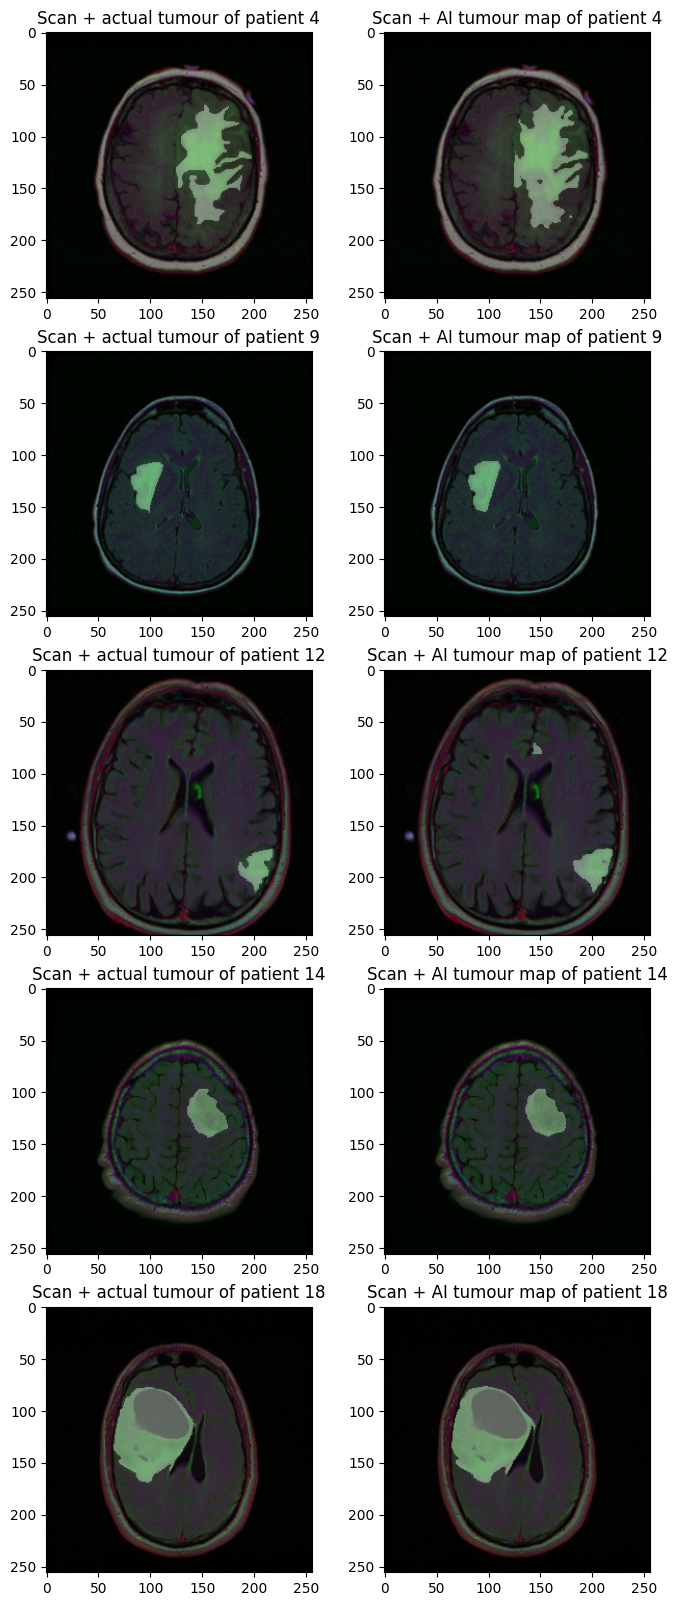

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:

count = 0
fig, axs = plt.subplots(5, 2, figsize = (8, 20))

for i in range(len(df_pred)):
  if count < 5 and df_pred['has_mask'][i] == 1:
    plt.figure()
    axs[count][0].imshow(cv2.imread(df_pred.image_path[i]))
    axs[count][0].imshow(cv2.imread(df_pred.mask_path[i]), alpha = 0.3, cmap = 'jet')
    axs[count][0].title.set_text("Scan + actual tumour of patient %d" %(i+1))

    pred_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][1].imshow(cv2.imread(df_pred.image_path[i]))
    axs[count][1].imshow(pred_mask, alpha = 0.3, cmap = 'gray')
    axs[count][1].title.set_text("Scan + AI tumour map of patient %d" %(i+1))
    count += 1